In [1]:
# === Celda 1: imports y datos base ===
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# Cargamos el dataset de cáncer (clasificación binaria)
cancer = load_breast_cancer()

# Fijamos aleatoriedad y generamos 50 características de ruido
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))

# Apilamos: primeras 30 son reales, siguientes 50 son ruido (80 en total)
X_w_noise = np.hstack([cancer.data, noise])
y = cancer.target

# Split 50/50 como en el ejemplo del libro
X_train, X_test, y_train, y_test = train_test_split(
    X_w_noise, y, random_state=0, test_size=0.5
)

X_train.shape, X_test.shape


((284, 80), (285, 80))

X_train: (284, 80)  -> X_train_selected: (284, 40)


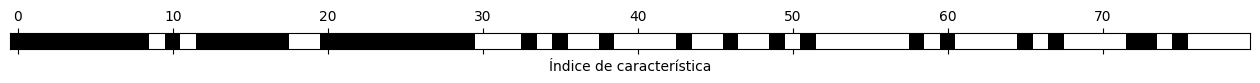

Score con todas las features: 0.951
Score solo con seleccionadas: 0.933


In [7]:
# === Celda 2: Univariate feature selection ===
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.linear_model import LogisticRegression

# Seleccionamos el 50% de las características con mejor relación con y
select = SelectPercentile(score_func=f_classif, percentile=50)
select.fit(X_train, y_train)

# Transformamos train y test
X_train_selected = select.transform(X_train)
X_test_selected  = select.transform(X_test)

print("X_train:", X_train.shape, " -> X_train_selected:", X_train_selected.shape)

# Visualizar máscara de selección (negro=True=seleccionada)
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Índice de característica")
plt.yticks([])
plt.show()

# Entrenamos y comparamos regresión logística con y sin selección
lr = LogisticRegression(max_iter=3000)  # max_iter alto para evitar warnings
lr.fit(X_train, y_train)
print("Score con todas las features: {:.3f}".format(lr.score(X_test, y_test)))

lr.fit(X_train_selected, y_train)
print("Score solo con seleccionadas: {:.3f}".format(lr.score(X_test_selected, y_test)))


X_train: (284, 80)  -> X_train_sfm: (284, 40)


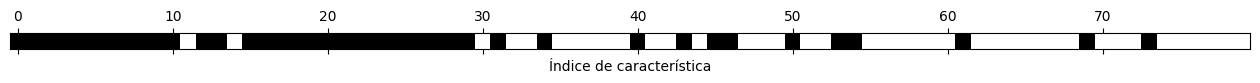

Test score (LR sobre SelectFromModel): 0.947


In [9]:
# === Celda 3: Model-based selection (feature_importances_) ===
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

# Umbral = "median" para quedarnos con ~la mitad según importancias
sfm = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold="median"
)

sfm.fit(X_train, y_train)
X_train_sfm = sfm.transform(X_train)
X_test_sfm  = sfm.transform(X_test)

print("X_train:", X_train.shape, " -> X_train_sfm:", X_train_sfm.shape)

# Máscara visual
mask = sfm.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Índice de característica")
plt.yticks([])
plt.show()

# Evaluación con LogisticRegression sobre las features seleccionadas
lr = LogisticRegression(max_iter=3000)
lr.fit(X_train_sfm, y_train)
print("Test score (LR sobre SelectFromModel): {:.3f}".format(lr.score(X_test_sfm, y_test)))


In [ ]:
# === Celda 4: RFE con RandomForest ===
from sklearn.feature_selection import RFE

# Mantener 40 características (como en el capítulo)
rfe = RFE(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    n_features_to_select=40
)
rfe.fit(X_train, y_train)

# Visual de la máscara
mask = rfe.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Índice de característica")
plt.yticks([])
plt.show()

# Transformaciones
X_train_rfe = rfe.transform(X_train)
X_test_rfe  = rfe.transform(X_test)

# 1) LogisticRegression sobre las features seleccionadas por RFE
lr = LogisticRegression(max_iter=3000)
lr.fit(X_train_rfe, y_train)
print("Test score (LR sobre RFE): {:.3f}".format(lr.score(X_test_rfe, y_test)))

# 2) (Opcional) Score del modelo interno (RandomForest) que usa RFE
print("Test score (modelo interno RFE): {:.3f}".format(rfe.score(X_test, y_test)))
